In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, log_loss
import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history
from umap import UMAP
import matplotlib.axes as axes
import yaml
import json
import joblib

In [2]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


preproc = config['preprocessing']
training = config['train']

In [36]:
preproc

{'train_path': '../data/raw/train_orig.csv',
 'unique_values_path': '../data/processed/unique_values.json',
 'train_proc_path': '../data/processed/train_num.csv',
 'test_size': 0.2,
 'val_size': 0.16,
 'target_column': 'cat',
 'target_column_pred': 'cat_pred',
 'sum_columns': ['title', 'description', 'adomain', 'bundle'],
 'drop_columns': ['text', 'text_count'],
 'rename_columns': {'cat': 'cat_orig'},
 'unnecessary_words': ['google',
  'ru',
  'app',
  'apps',
  'com',
  'android',
  'apple',
  'lv'],
 'vectorizer_params': {'max_df': 0.9, 'max_features': 9000},
 'random_state': 10}

In [37]:
training

{'n_trials': 10,
 'random_state': 10,
 'target_column': 'cat',
 'model_path': '../models/model_svc_optuna.joblib',
 'study_path': '../models/study.joblib',
 'metrics_path': '../reports/metrics.json',
 'params_path': '../reports/best_params.json'}

In [7]:
RAND = preproc["random_state"]
target_column = preproc["target_column"]
target_column_pred = preproc["target_column_pred"]

## Обучение ML model

Функция проверки на переобучение

In [29]:
def check_overfitting(model,
                      X_train: pd.DataFrame,
                      y_train: np.ndarray,
                      X_test: pd.DataFrame,
                      y_test: np.ndarray) -> None:
    """
    Проверяет модель на переобучение и выводит значения ROC-AUC
    на тренировочной и тестовой выборках
    :param model: модель типа классификатор
    :param X_train: датафрейм признаков обучающего набора данных
    :param y_train: массив меток обучающего набора данных
    :param X_test: датафрейм признаков тестового набора данных
    :param y_test: массив меток тестового набора данных
    :return: None
    """
    y_prob_train = model.predict_proba(X_train)
    y_prob_test = model.predict_proba(X_test)

    # Accuracy не применяем, т. к. при дисбалансе классов Accuracy всегда
    # высокая из-за того что легко попасть в имбалансный класс

    print(f'\nROC-AUC train: %.3f' %
          roc_auc_score(y_true=y_train,
                        y_score=y_prob_train,
                        multi_class='ovr'))
    print(f'ROC-AUC test: %.3f' %
          roc_auc_score(y_true=y_test,
                        y_score=y_prob_test,
                        multi_class='ovr'))

Подготовка данных

In [ ]:
numbers_words = pd.read_csv(
    preproc['train_proc_path'], index_col=0, keep_default_na=False)
df_plus_cats = pd.read_csv(
    preproc['train_path'], index_col=0, keep_default_na=False)

In [30]:
X = numbers_words
y = df_plus_cats[target_column].values

In [31]:
# указываем stratify, чтобы захватить и в test и в train по объектам из каждого класса
# чтобы потом посчитать рок аук
X_train, X_test, y_train, y_test = train_test_split(X,                                                    
                                                    y,
                                                    test_size=preproc["test_size"],
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=RAND)
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=preproc["val_size"],
                                                    stratify=y_train,
                                                    shuffle=True,
                                                    random_state=RAND)

В более подробной версии, представленной в отдельном проекте, выяснили,  
что при сравнении бейзлайнов Catboost, Logreg и SVM,  
SVM показал наилучший результат.  
Что немудрено, т. к. 
SVM как раз особенно хорошо подходит для классификации сложных, но небольших наборов данных.  
А наш датасет состоит из ~2500 строк и большого количества признаков

### SVM baseline

In [29]:
svc = SVC(random_state=RAND,
          probability=True)
svc.fit(X_train_,
        y_train_)

In [10]:
# Проверка на переобучение
check_overfitting(svc, X_train_, y_train_, X_test, y_test)


ROC-AUC train: 1.000
ROC-AUC test: 0.983


### Tuning

Целевая функция


In [32]:
def objective_svc(trial: optuna.Trial,
                  X_train_: pd.DataFrame,
                  X_val: np.ndarray,
                  y_train_: pd.DataFrame,
                  y_val: np.ndarray,
                  random_state: int) -> float:
    """
    Целевая функция для оптимизации параметров модели Support Vector Classifier
    с использованием библиотеки Optuna
    :param trial: объект, представляющий итерацию выбора гиперпараметров модели во
    время оптимизации
    :param X_train_: датасет признаков для обучения модели
    :param X_val: датасет признаков для валидации модели
    :param y_train_: целевые значения соответствующие датасету признаков для обучения модели
    :param y_val: целевые значения соответствующие датасету признаков для валидации модели
    :param random_state: число, фиксирующее начальное состояние для воспроизводимости результатов
    :return: значение ROC-AUC метрики для валидационных данных
    """
    # Словарь, содержащий гиперпараметры модели SVC,
    # для каждой итерации trial генерируются разные
    params = {
        # Меньшее значение C ведет к более широкой полосе, но большему числу нарушений зазора
        # При переобучении сократить С
        "C": trial.suggest_categorical("C", [0.01, 1, 10, 100]),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]),
        # Если модель переобучается, тогда надо уменьшить значение gamma, а 
        # если недообучается — то увеличить его
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "probability": True,
        "break_ties": trial.suggest_categorical("break_ties", [True, False]),
        "random_state": random_state
    }

    if params["kernel"] == "poly":
       params["degree"] = trial.suggest_int("degree", 3, 5, 10)
    # coef0 управляет тем, насколько сильно полиномы высокой степени влияют 
    # на модель в сравнении с полиномами низкой степени
    if params["kernel"] in ["poly", "sigmoid"]:
       params["coef0"] = trial.suggest_float(
           "coef0", 0.0, 5.0)

    # SVC имеет встроенную 5-fold кросс-валидацию при
    # включённом параметре probability

    # Создание объекта модели SVC с гиперпараметрами,
    # сгенерированными для текущей итерации
    model = SVC(**params)
    # Обучение
    model.fit(X_train_, y_train_)

    # Предсказание
    y_pred = model.predict_proba(X_val)
    roc_auc_predict = roc_auc_score(y_true=y_val,
                                    y_score=y_pred,
                                    multi_class='ovr')

    return roc_auc_predict


Работа Оптюны

In [ ]:
study_svc = optuna.create_study(
    direction="maximize", study_name="SVC_Optuna")


def func(trial: optuna.Trial) -> function:
    """
    Обёртка для вызова функции objective_svc с передачей аргументов
    через объект trial
    :param trial: объект, представляющий итерацию выбора гиперпараметров модели во
        время оптимизации
    :return: функция objective_svc, которая в свою очередь затем вернёт значение
        ROC-AUC метрики для валидационных данных
    """
    return objective_svc(trial,
                         X_train_,
                         X_val,
                         y_train_,
                         y_val,
                         random_state=RAND)


study_svc.optimize(func, n_trials=10, show_progress_bar=True)

[I 2023-05-12 22:17:43,205] A new study created in memory with name: SVC_Optuna
c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-05-12 22:20:59,355] Trial 0 finished with value: 0.9703563272873449 and parameters: {'C': 100, 'kernel': 'sigmoid', 'gamma': 'scale', 'break_ties': True, 'coef0': 3.0525292064659872}. Best is trial 0 with value: 0.9703563272873449.


c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:26:20,019] Trial 1 finished with value: 0.9731336382515743 and parameters: {'C': 100, 'kernel': 'poly', 'gamma': 'scale', 'break_ties': False, 'degree': 3, 'coef0': 1.8294640701763005}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:28:31,389] Trial 2 finished with value: 0.9348148828386253 and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto', 'break_ties': True}. Best is trial 1 with value: 0.9731336382515743.


c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:31:41,328] Trial 3 finished with value: 0.9515605273314194 and parameters: {'C': 10, 'kernel': 'poly', 'gamma': 'auto', 'break_ties': False, 'degree': 3, 'coef0': 2.174538323386762}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:35:29,250] Trial 4 finished with value: 0.9727616050168232 and parameters: {'C': 10, 'kernel': 'linear', 'gamma': 'auto', 'break_ties': False}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:39:09,944] Trial 5 finished with value: 0.9513447684815183 and parameters: {'C': 0.01, 'kernel': 'linear', 'gamma': 'auto', 'break_ties': False}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:41:31,850] Trial 6 finished with value: 0.9561833602601969 and parameters: {'C': 100, 'kernel': 'sigmoid', 'gamma': 'scale', 'break_ties': False, 'coef0': 4.28690579034802}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:44:50,451] Trial 7 finished with value: 0.9740889371833445 and parameters: {

c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:49:59,197] Trial 9 finished with value: 0.9363089112763846 and parameters: {'C': 0.01, 'kernel': 'poly', 'gamma': 'auto', 'break_ties': False, 'degree': 3, 'coef0': 2.952106676090238}. Best is trial 7 with value: 0.9740889371833445.


In [33]:
print(f"\tBest value (auc): {study_svc.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_svc.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.97409
	Best params:
		C: 1
		kernel: linear
		gamma: scale
		break_ties: False


In [ ]:
best_params_path = training['params_path']

with open(best_params_path, 'w') as f:
    json.dump(study_svc.best_params, f)

In [9]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study_svc)
fig.show(config=plotly_config)

C:\Users\ABC\AppData\Local\Temp\ipykernel_20860\2794792167.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



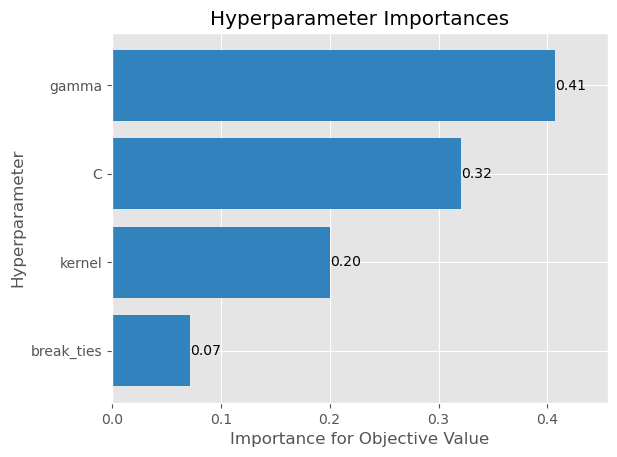

In [10]:
plot_param_importances(study_svc);

Обучение на лучших параметрах

In [11]:
svc_optuna = SVC(**study_svc.best_params,
                 random_state=RAND,
                 probability=True)
svc_optuna.fit(X_train_,
               y_train_)

SVC(C=1, kernel='linear', probability=True, random_state=10)

In [12]:
check_overfitting(svc_optuna, X_train_, y_train_, X_test, y_test)


ROC-AUC train: 1.000
ROC-AUC test: 0.984


In [44]:
model_path = training['model_path']

# save model
joblib.dump(svc_optuna, model_path)

['../models/model_svc_optuna.joblib']

In [69]:
def get_metrics(y_test: np.array,
                y_pred: np.array,
                y_proba: np.array,
                multi_class: str="ovr",
                average: str="weighted") -> dict:
    dict_metrics = {
        "roc_auc": round(roc_auc_score(y_test, y_proba, multi_class=multi_class), 3),
        "precision": round(precision_score(y_test, y_pred, average=average), 3),
        "recall": round(recall_score(y_test, y_pred, average=average), 3),
        "f1": round(f1_score(y_test, y_pred, average=average), 3),
        "logloss": round(log_loss(y_test, y_proba), 3),
    }

    return dict_metrics

In [70]:
# save metrics
metrics_path = training["metrics_path"]

metrics = get_metrics(y_test,
                      svc_optuna.predict(X_test),
                      svc_optuna.predict_proba(X_test),
                      "ovr",
                      "weighted")
with open(metrics_path, "w") as f:
    json.dump(metrics, f)

In [71]:
# check
with open(metrics_path) as json_file:
    metrics = json.load(json_file)
metrics

{'roc_auc': 0.983,
 'precision': 0.926,
 'recall': 0.895,
 'f1': 0.894,
 'logloss': 0.338}

Значение на тестовой выборке получилось выше, чем до тюнинга

Далее я также отдельно попробовал:
- Применял масштабирование при помощи StandardScaler
- Обучал на других ядрах при прочих дефолтных параметрах  
- Увеличивал С и гамма  
- Пробовал полиномы с большими степенями и средними значениями гамма и С

Но результат первой подборки оказался всё равно лучше

## Predict

In [77]:
numbers_words[target_column_pred] = svc_optuna.predict(numbers_words)

In [78]:
numbers_words

,abahbrcih,abc,abenteuern,ability,ablians,about,abroad,absolviert,absorbing,accepted,...,язык,яндекс,янина,японский,яркий,ярко,ярмарка,ярославль,яф,cat_pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel


In [92]:
def get_df_predict_origin(df_predict: pd.DataFrame,
                          df_origin: pd.DataFrame,
                          drop_columns: list,
                          rename_columns: dict) -> pd.DataFrame:
    """
    Соединяет в один датафрейм предсказанные категории и изначальные
    :param df_predict: датафрейм с признаками и предсказанными значениями целевой
        переменной -- категории
    :param df_origin: датафрейм с признаками и изначальными значениями категории
    :param drop_columns: колонки для удаления
    :param rename_columns: колонки для переименования
    :return: датафрейм с признаками и предсказанными и изначальными значениями категории
    """
    df_origin = df_origin.reset_index(drop=True)
    # Соединяем только одну колонку cat_pred со всем датасетом df_origin
    df = pd.concat([df_predict[target_column_pred],
                    df_origin],
                   axis=1)
    # Удаляем ненужные и переименовываем столбцы
    df.drop(drop_columns, axis=1, inplace=True, errors='ignore')
    df.rename(rename_columns, axis=1, inplace=True, errors='ignore')
    
    return df

In [93]:
df_predict_origin = get_df_predict_origin(numbers_words,
                                          df_plus_cats,
                                          preproc['drop_columns'],
                                          preproc['rename_columns'])
df_predict_origin

,cat_pred,title,description,adomain,bundle,cat_orig
0,Hobbies & Interests,Приложения в Google Play Строки от МТС,"Книги, подкасты и аудиокниги",play.google.com,,Hobbies & Interests
1,Hobbies & Interests,,,play.google.com,,Hobbies & Interests
2,Hobbies & Interests,,,innogames.com,com.innogames.elvenar,Hobbies & Interests
3,Hobbies & Interests,,,mamba.ru,ru.mamba.client,Hobbies & Interests
4,Hobbies & Interests,,,bigo.sg,sg.bigo.live,Hobbies & Interests
...,...,...,...,...,...,...
2476,Travel,Ksenukai - LVNr.7Maijs - Page 1,SIRSNGM SARUNM. NO PADOMA LDZ RISINJUMAM Piedv...,view.publitas.com,,Travel
2477,Travel,Ksenukai - LVZibenigiepiedavajumi121505 - Page 1,12.15.05.2022. 4 TIKAI DIENAS ZIBENGIE PIEDVJU...,view.publitas.com,,Travel
2478,Travel,Ksenukai - LVZibenigiepiedavajumi161906 - Page 1,LVZibenigiepiedavajumi161906,view.publitas.com,,Travel
2479,Travel,Ksenukai - LVNr.10JunijsJulijs - Page 1,IZ NO PADOMA LDZ RISINJUMAM P RDOAN Piedvjums ...,view.publitas.com,,Travel


In [94]:
if target_column in preproc['rename_columns']:
    target_column = preproc['rename_columns'][target_column]
if target_column_pred in preproc['rename_columns']:
    target_column_pred = preproc['rename_columns'][target_column_pred]

In [ ]:
def plot_text(ax: axes.Axes) -> None:
    """
    Добавляет аннотации с процентными значениями к каждому столбцу на столбчатой диаграмме
    :param ax: область для построения графиков в системе координат
    :return: None
    """
    # Для каждого столбца p
    for p in ax.patches:
        # Получение значения процента в формате строки
        percentage = '{:.1f}%'.format(p.get_width())
        ax.annotate(
            # Текст аннотации
            percentage,
            # Координата xy
            (p.get_width(), p.get_y() + p.get_height()),
            # Центрирование текста
            ha='center',
            va='center',
            xytext=(20, 10),
            # Точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)


def barplot_category_percents(sr: pd.Series, title: str) -> None:
    """
    Строит барплот с количеством объектов в процентном соотношении
    по категориям
    :param title: название барплота
    :param sr: пандас серия, для которой будет строиться барплот
    :return: None, значения не возвращает, но итогом работы функции является
        отображение барплота
    """
    # Нормирование на размер датасета
    norm_target = (sr
                   .value_counts(normalize=True)
                   .mul(100)
                   .rename('percent')
                   .reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(y='index', x='percent', data=norm_target, orient='h')

    plot_text(ax)

    plt.title(title, fontsize=20)
    plt.xlabel('Проценты', fontsize=14)
    plt.ylabel('Категория', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14);

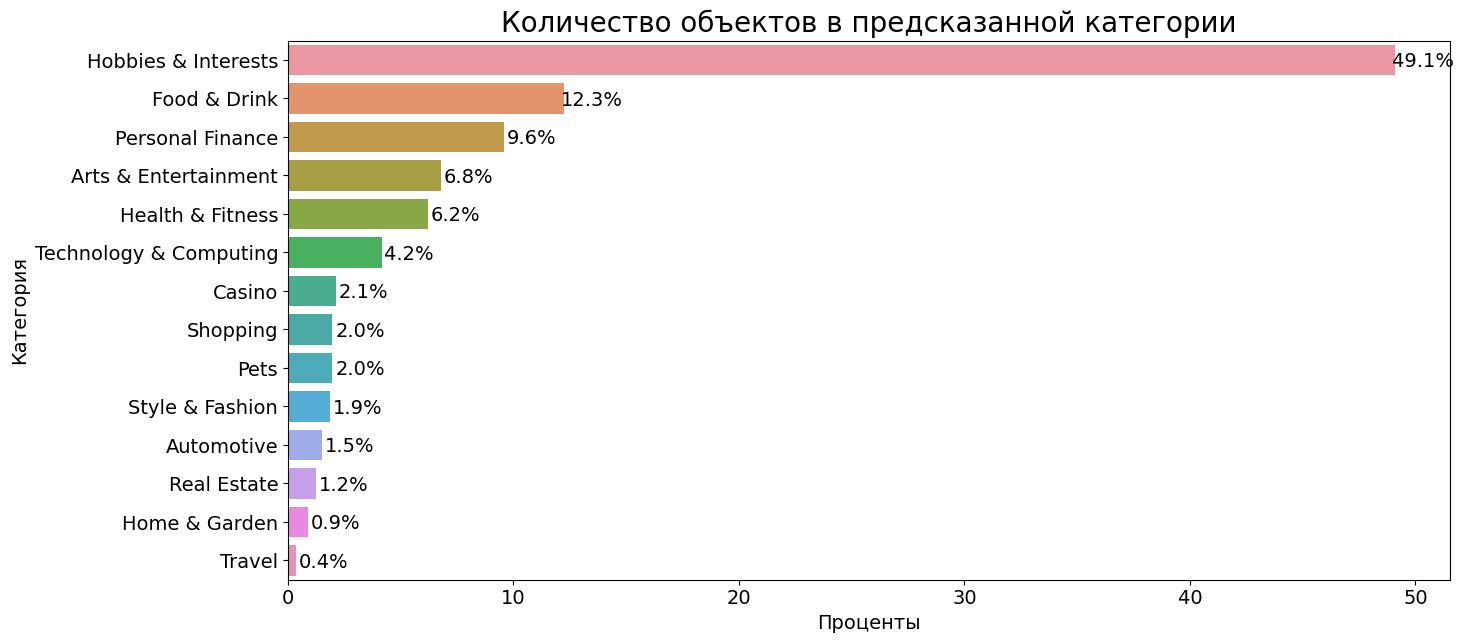

In [82]:
barplot_category_percents(df_predict_origin[target_column_pred],
                          'Количество объектов в предсказанной категории')

Видим, что распределение в целом похожее на то, которое делали для изначальных категорий

In [85]:
def embeddings_diagram(X: pd.DataFrame, X_name: str) -> None:
    """
    Принимает набор данных. Создаёт эмбеддинги сниженной размерности.
    Предсказывает для него значения целевой переменной. 
    Рисует диаграмму рассеяния
    :param X: набор данных
    :param X_name: имя набора данных
    :return: None, значения не возвращает, но итогом работы функции является
        отображение диаграммы
    """
    um = UMAP(n_components=3, random_state=RAND, n_neighbors=15, min_dist=0.1)
    X_embedding = um.fit_transform(X)

    y_pred = svc_optuna.predict(X)

    plt.figure(figsize=(13, 8))
    plt.title(f'Диаграмма рассеяния предсказанных значений целевой переменной '
              f'на наборе данных: {X_name}',
              fontsize=14)
    sns.scatterplot(x=X_embedding[:, 0],
                    y=X_embedding[:, 1],
                    hue=y_pred,
                    s=100,
                    legend='full')

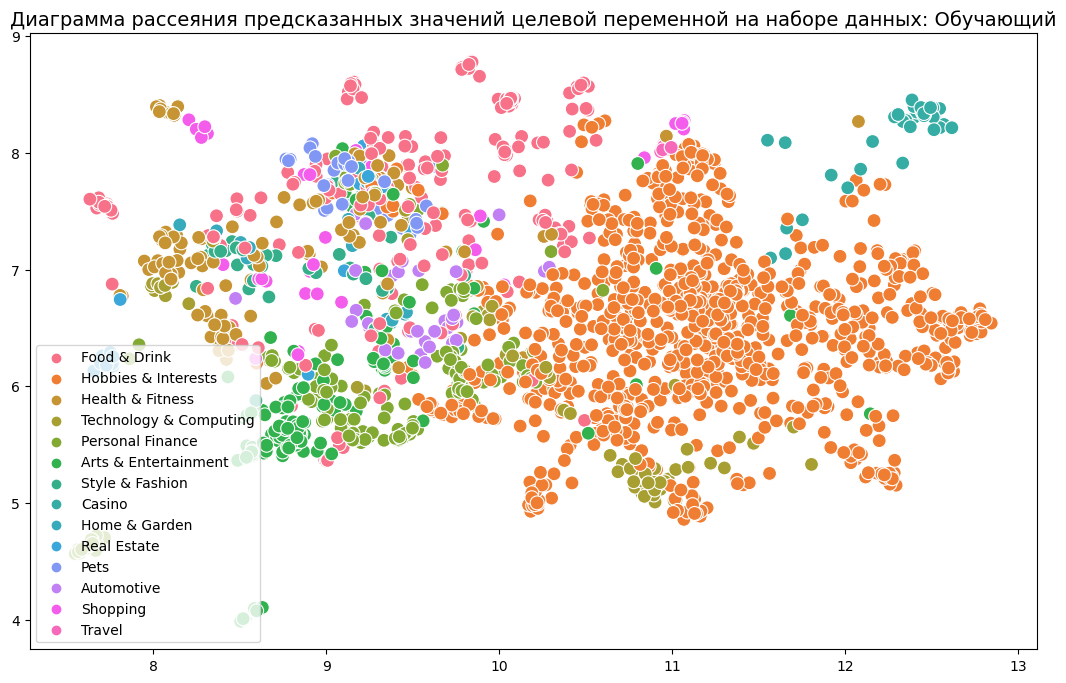

In [86]:
embeddings_diagram(X_train, "Обучающий")

Видны территории категорий со своими границами, с некоторыми выбросами.

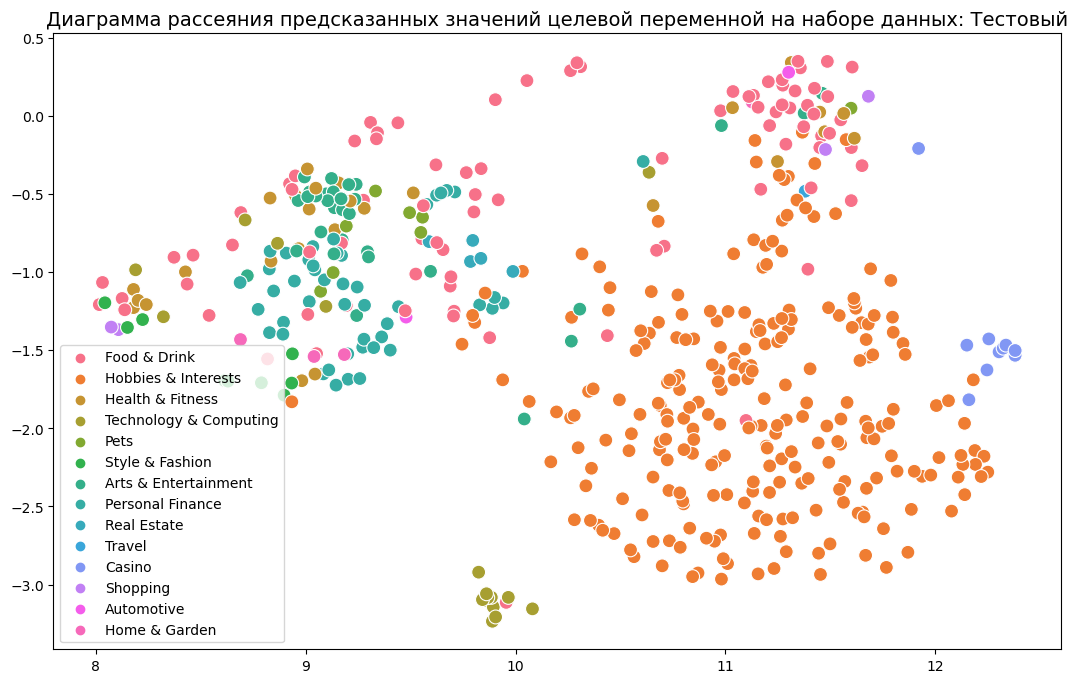

In [87]:
embeddings_diagram(X_test, "Тестовый")

На тесте разделение есть, но категории расположены в других местах.  
(Алгоритм не гарантирует что положение будет сохранено,  
т.к. задача нахожождения наилучшей проекции имеет много решений)  
Главное, что категории группируются, это хорошо

Посмотрим визуально датасет.

In [95]:
df_predict_origin[2000:2010]

,cat_pred,title,description,adomain,bundle,cat_orig
2000,Personal Finance,Дебетовая карта Tinkoff Black Дебетовая карта ...,Дебетовая карта с кэшбэком до 30. Получайте 6 ...,tinkoff.ru,,Personal Finance
2001,Personal Finance,Мгновенные денежные переводы в страны СНГ Быст...,"Выгодные, быстрые и удобные переводы денег за ...",tinkoff.ru,,Personal Finance
2002,Personal Finance,Кредитная карта с кешбэком МТС CASHBACK Мир оф...,Оформите кредитную кешбэк карту от МТС Банка и...,mtsbank.ru,,Personal Finance
2003,Personal Finance,Оформить заявку на кредитную карту онлайн,Оформить кредитную карту онлайн. Получить кред...,tinkoff.ru,,Personal Finance
2004,Personal Finance,Кредиты для бизнеса Кредиты на открытие и разв...,Кредит для малого бизнеса до 10 млн без залога...,tinkoff.ru,,Personal Finance
2005,Personal Finance,Акция от Халвы на покупку одежды - рассрочка о...,Обнови гардероб с Халвой 18 месяца рассрочки н...,halvacard.ru,,Personal Finance
2006,Personal Finance,Оборотный кредит Кредит на пополнение оборотны...,Оборотный кредит до 10 млн . Кредит на пополне...,tinkoff.ru,,Personal Finance
2007,Personal Finance,Черная пятница с Халвой оформить карту с расср...,Черная пятница вместе с картой рассрочки Халва...,halvacard.ru,,Personal Finance
2008,Personal Finance,Рефинансирование кредитов от наша ставка - реф...,Банк Хоум Кредит предлагает программу рефинанс...,homecredit.ru,homecredit.ru,Personal Finance
2009,Personal Finance,Нельзя войти на сайт Сбербанка в этом браузере.,,sberbank.ru,,Personal Finance


In [96]:
df_predict_origin[df_predict_origin[target_column_pred]
    != df_predict_origin[target_column]].shape

(90, 6)

Количество отличающихся предсказанных и изначальных значений составляет примерно 4%

После визуального осмотра можно сказать, что среди различающихся значений модель где-то вернее предсказала категорию, где-то нет.
Но в общем и целом показала результат не хуже, чем изначальная разметка.